In [1]:
#Example 1:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# load datasets
counts = pd.read_csv('BridgeBicycles.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('BridgeWeather.csv', index_col='DATE', parse_dates=True)

In [3]:
# compute the total daily bicycle traffic, 
## and put this in its own dataframe:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

In [4]:
# account for 7-day a week in the daily data
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [5]:
# add holidays as an indicator
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2018', '2019')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

In [6]:
print(holidays)

DatetimeIndex(['2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28',
               '2018-07-04', '2018-09-03', '2018-10-08', '2018-11-12',
               '2018-11-22', '2018-12-25', '2019-01-01'],
              dtype='datetime64[ns]', freq=None)


(8, 17)

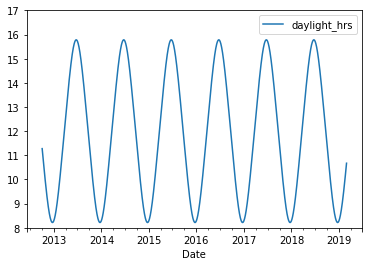

In [7]:
# use the standard astronomical calculation to add this information:

def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)


In [8]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

In [9]:
#
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [10]:
#print(daily['annual'])

In [11]:
#
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,5.60,1,0.000000
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,5.65,1,0.002740
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,5.95,1,0.005479
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,6.05,1,0.008219
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,6.05,1,0.010959


In [12]:
# Drop any rows with null values
from sklearn.linear_model import LinearRegression
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'Temp (C)', 'dry day', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

In [13]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual,predicted
Date,,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,5.60,1,0.000000,3465.566970
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,5.65,1,0.002740,3317.358046
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,5.95,1,0.005479,3131.083155
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,6.05,1,0.008219,1836.601244
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,6.05,1,0.010959,1750.540950


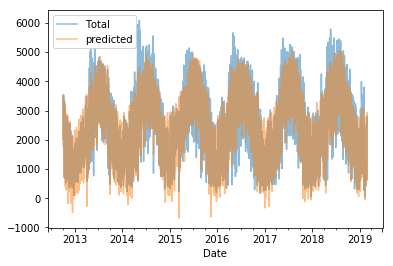

In [14]:
#
daily[['Total', 'predicted']].plot(alpha=0.5);

In [15]:
#
params = pd.Series(model.coef_, index=X.columns)
params

Mon               -846.367225
Tue               -618.556985
Wed               -641.927448
Thu               -804.857796
Fri              -1111.333533
Sat              -2441.656625
Sun              -2521.386217
holiday          -1297.946303
daylight_hrs       111.606342
PRCP           -177096.154961
Temp (C)           421.866992
dry day            486.414446
annual              45.819384
dtype: float64

In [16]:
#
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

In [17]:
#
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

                effect    error
Mon             -846.0     73.0
Tue             -619.0     72.0
Wed             -642.0     72.0
Thu             -805.0     75.0
Fri            -1111.0     70.0
Sat            -2442.0     69.0
Sun            -2521.0     70.0
holiday        -1298.0    221.0
daylight_hrs     112.0      7.0
PRCP         -177096.0  11293.0
Temp (C)         422.0     18.0
dry day          486.0     26.0
annual            46.0      6.0
